In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate, true_positive_rate, false_positive_rate, false_negative_rate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import ConfusionMatrixDisplay

# Load the cleaned dataset
data = pd.read_csv('cleaned_communities_crime_data.csv')

# Define the target and features
target = 'ViolentCrimesPerPop'
features = data.drop(columns=[target])
sensitive_feature = 'racepctblack'

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['ViolentCrimesPerPop_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive feature
data['racepctblack_bin'] = pd.cut(data['racepctblack'], bins=5, labels=False)


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, data['ViolentCrimesPerPop_binary'], test_size=0.2, random_state=42
)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)

# Define custom metric functions
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, zero_division=0)

def recall(y_true, y_pred):
    return recall_score(y_true, y_pred, zero_division=0)

def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=0)

# Compute metrics for different groups
metrics = MetricFrame(
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics:")
print(metrics.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups:")
print(metrics.by_group)


Overall Metrics:
accuracy     0.802198
precision    0.620690
recall       0.720000
f1           0.666667
dtype: float64

Metrics by Sensitive Feature Groups:
                  accuracy  precision    recall        f1
racepctblack_bin                                         
0                 0.816901   0.461538  0.500000  0.480000
1                 0.666667   0.714286  0.833333  0.769231
2                 0.800000   0.750000  1.000000  0.857143
3                 0.666667   0.500000  1.000000  0.666667
4                 1.000000   1.000000  1.000000  1.000000


In [3]:
# Custom Metric Functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

# Define difference functions
def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)


In [4]:
# Calculate fairness metrics for the base model
dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
eod = equalized_odds_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
fprd = false_positive_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
fnrd = false_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
srd = selection_rate_difference(y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
for_diff = false_omission_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
tnr_diff = true_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])

print(f"Demographic Parity Difference: {dpd}")
print(f"Equalized Odds Difference: {eod}")
print(f"False Positive Rate Difference: {fprd}")
print(f"False Negative Rate Difference: {fnrd}")
print(f"Selection Rate Difference: {srd}")
print(f"False Omission Rate Difference: {for_diff}")
print(f"True Negative Rate Difference: {tnr_diff}")

# Reweighing
def compute_sample_weights(data, sensitive_features, target):
    df = data.copy()
    df['weight'] = 1.0
    
    # Calculate the prevalence of each group
    group_counts = df.groupby(sensitive_features).size()
    total_count = len(df)
    
    for group, count in group_counts.items():
        group_weight = total_count / (len(group_counts) * count)
        df.loc[df[sensitive_features] == group, 'weight'] = group_weight
    
    return df['weight']


Demographic Parity Difference: 0.8169014084507042
Equalized Odds Difference: 0.6666666666666666
False Positive Rate Difference: nan
False Negative Rate Difference: 0.5
Selection Rate Difference: 0.8169014084507042
False Omission Rate Difference: nan
True Negative Rate Difference: nan


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_12144\2464221156.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  return fp / (fp + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_12144\2464221156.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_12144\2464221156.py:19: RuntimeWarning: invalid value encountered in longlong_scalars
  return tn / (tn + fp)


In [5]:
# Compute sample weights for training data
sample_weights = compute_sample_weights(data.loc[X_train.index], 'racepctblack_bin', 'ViolentCrimesPerPop_binary')

# Train a Random Forest model on the reweighed data
rf_model_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predict using the trained model
y_pred_rw = rf_model_rw.predict(X_test)

# Perform adversarial debiasing using Exponentiated Gradient Reduction on reweighed data
mitigator = ExponentiatedGradient(estimator=LogisticRegression(random_state=42), 
                                  constraints=DemographicParity())

mitigator.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'racepctblack_bin'])

y_pred_ad = mitigator.predict(X_test)

# Perform post-processing using ThresholdOptimizer on debiased results
postprocess_est = ThresholdOptimizer(estimator=mitigator, 
                                     constraints="equalized_odds", 
                                     prefit=True)

postprocess_est.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'racepctblack_bin'])

y_pred_pp = postprocess_est.predict(X_test, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])

# Function to compute and print metrics
def compute_and_print_metrics(y_true, y_pred, sensitive_features, stage):
    metrics_stage = MetricFrame(
        metrics={
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    print(f"Overall Metrics after {stage}:")
    print(metrics_stage.overall)
    print(f"\nMetrics by Sensitive Feature Groups after {stage}:")
    print(metrics_stage.by_group)
    return metrics_stage


C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s

Overall Metrics after Reweighing:
accuracy     0.824176
precision    0.680000
recall       0.680000
f1           0.680000
dtype: float64

Metrics by Sensitive Feature Groups after Reweighing:
                  accuracy  precision    recall        f1
racepctblack_bin                                         
0                 0.859155   0.600000  0.500000  0.545455
1                 0.666667   0.714286  0.833333  0.769231
2                 0.600000   0.666667  0.666667  0.666667
3                 0.666667   0.500000  1.000000  0.666667
4                 1.000000   1.000000  1.000000  1.000000
Overall Metrics after Adversarial Debiasing:
accuracy     0.703297
precision    0.458333
recall       0.440000
f1           0.448980
dtype: float64

Metrics by Sensitive Feature Groups after Adversarial Debiasing:
                  accuracy  precision    recall        f1
racepctblack_bin                                         
0                 0.788732   0.411765  0.583333  0.482759
1             

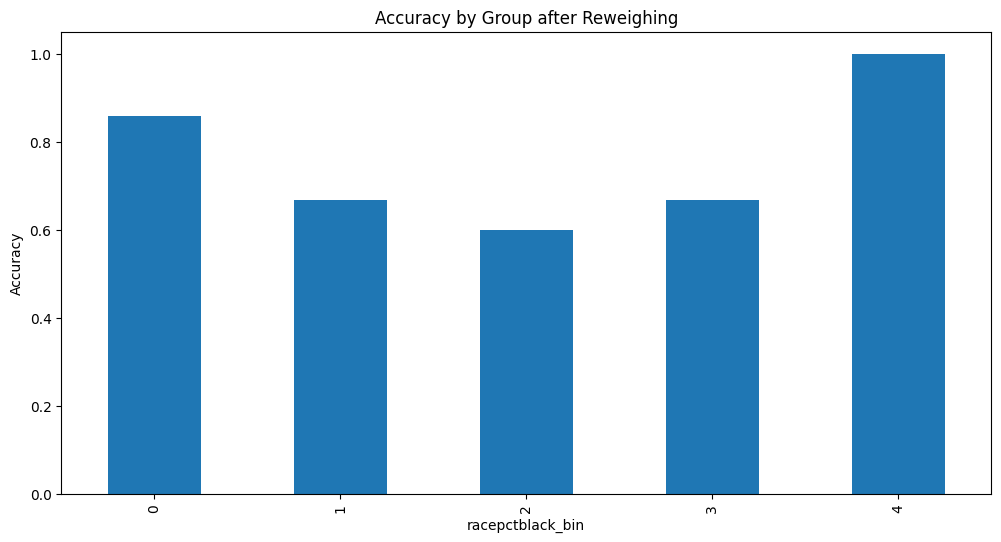

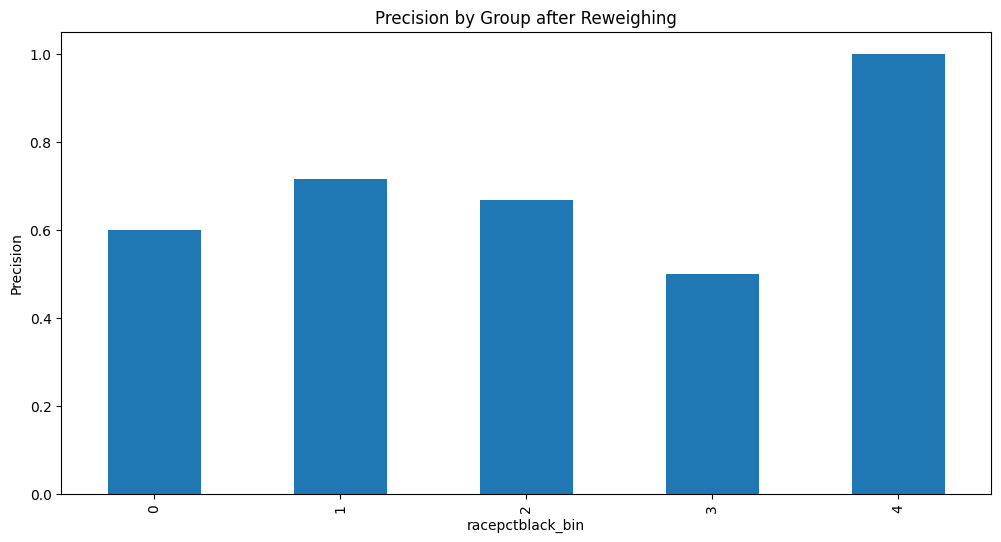

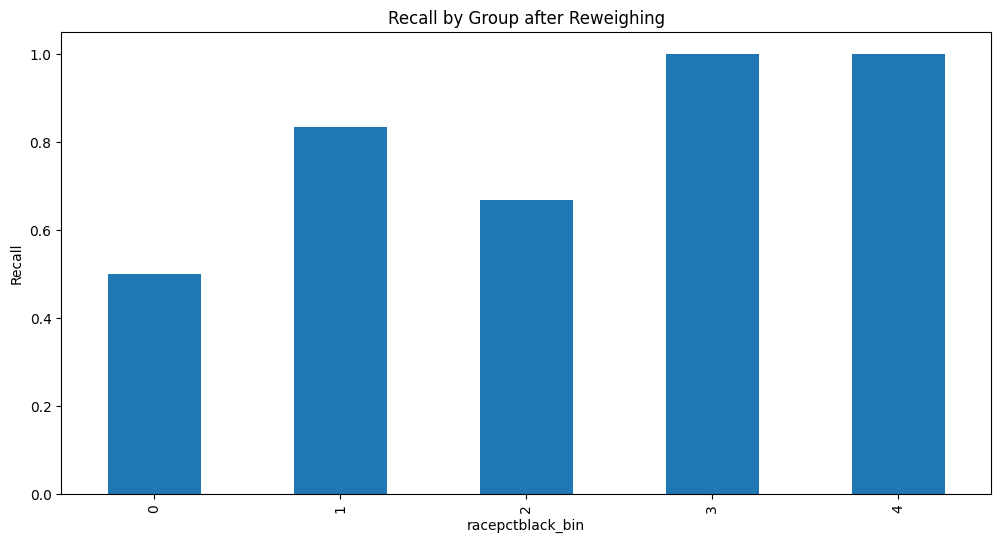

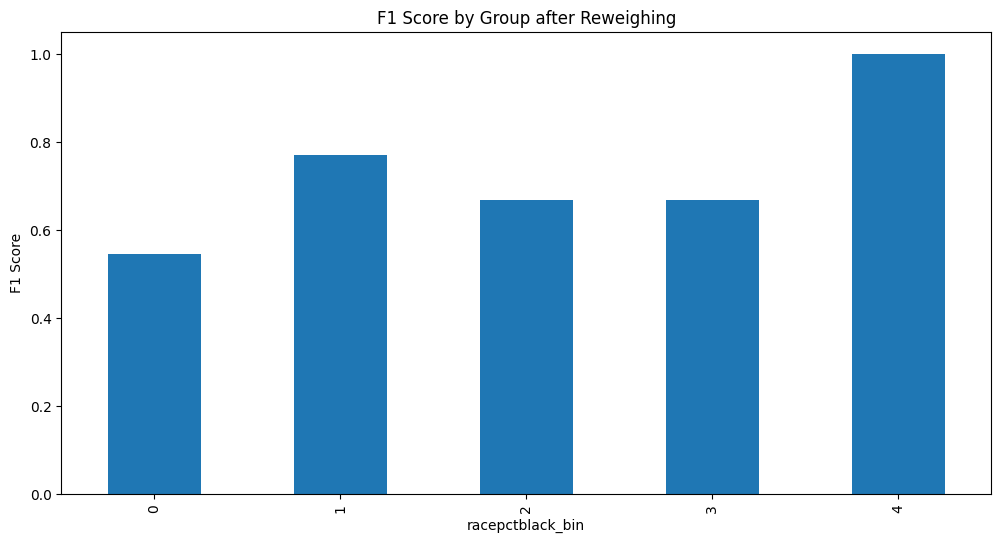

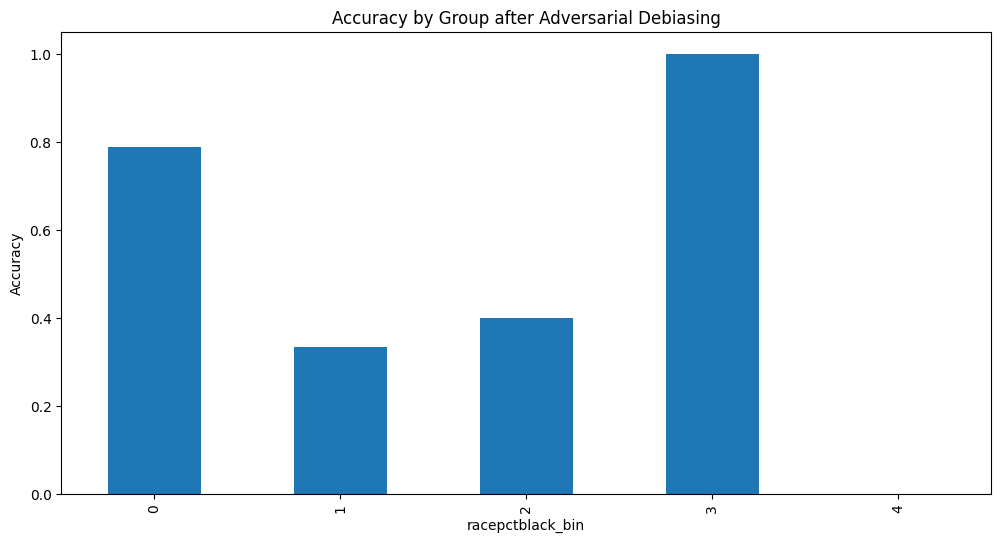

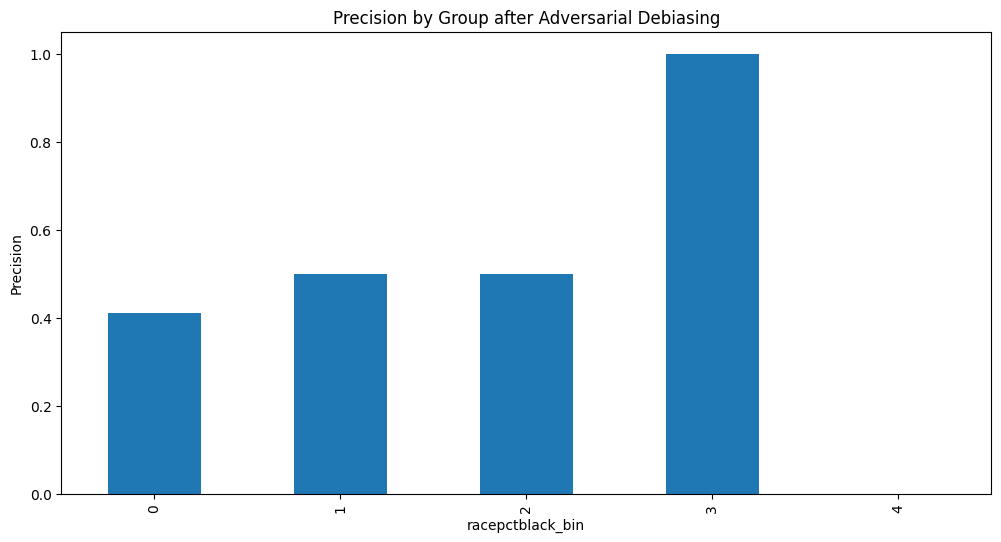

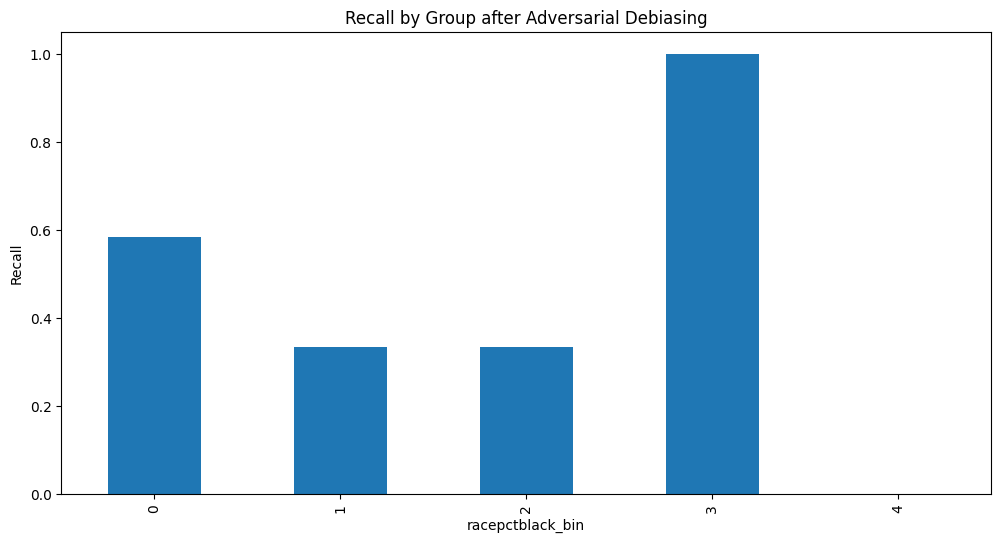

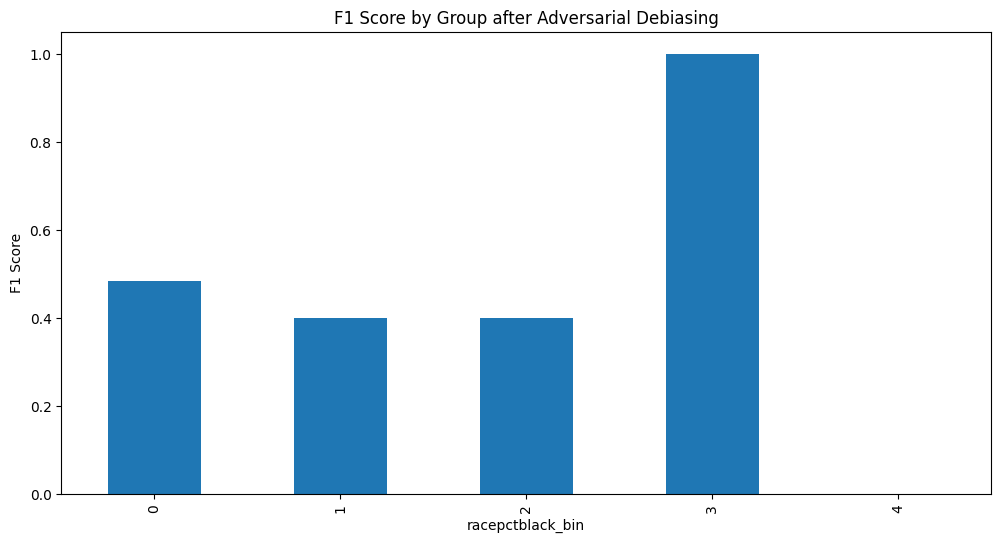

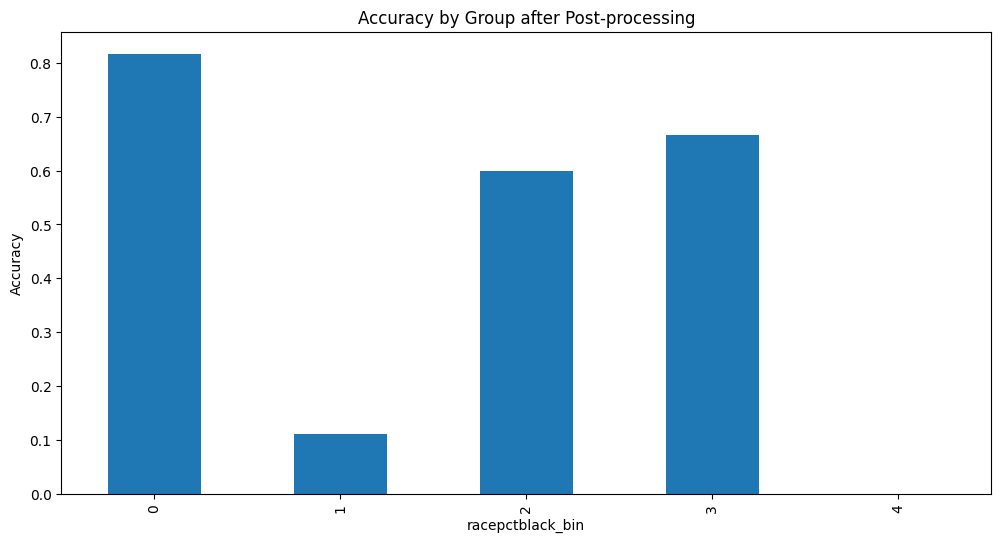

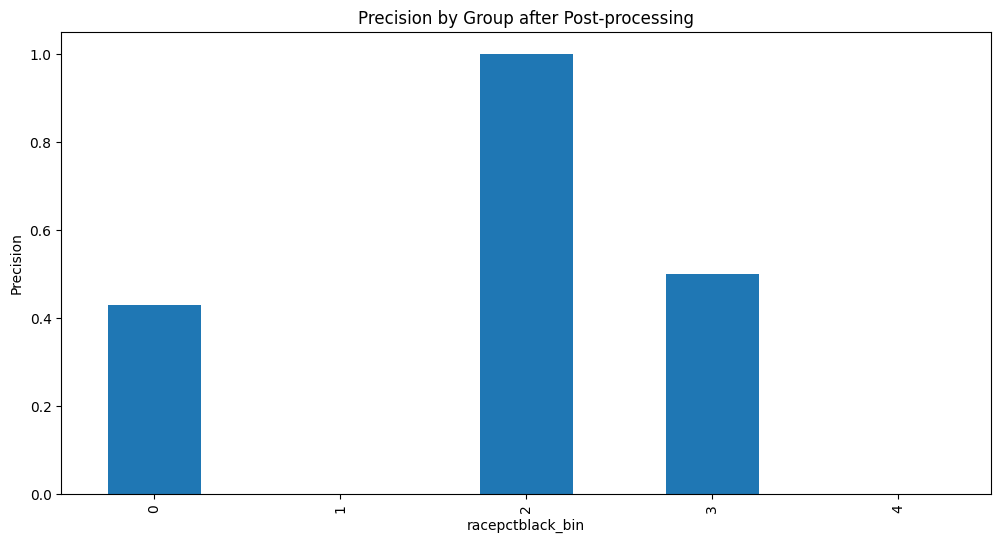

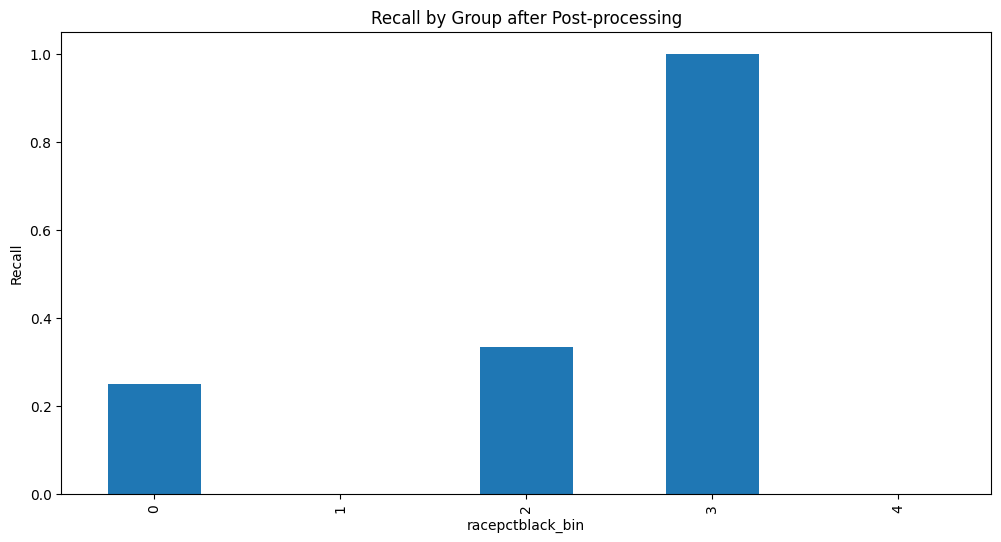

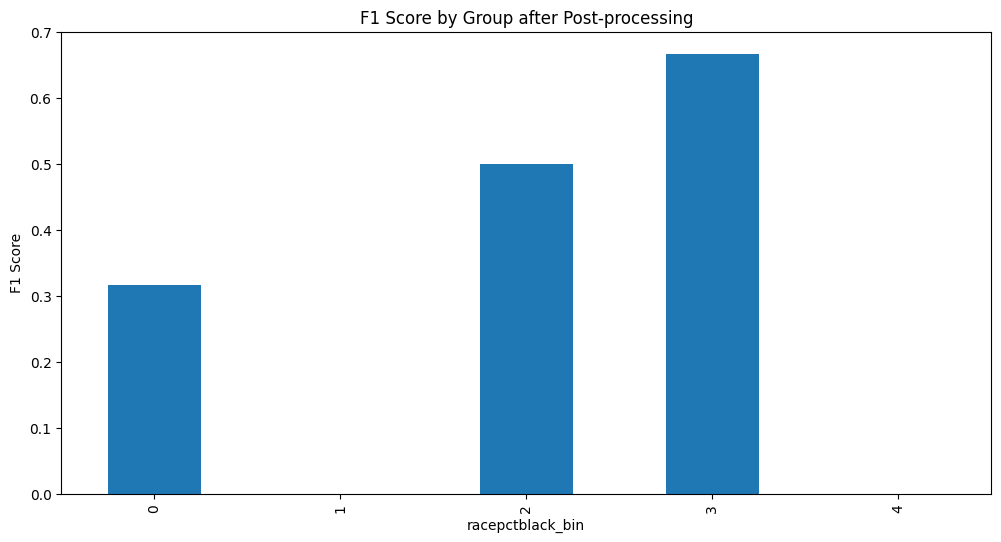

Done


In [6]:
# Compute and print metrics for each stage
metrics_rw = compute_and_print_metrics(y_test, y_pred_rw, data.loc[X_test.index, 'racepctblack_bin'], "Reweighing")
metrics_ad = compute_and_print_metrics(y_test, y_pred_ad, data.loc[X_test.index, 'racepctblack_bin'], "Adversarial Debiasing")
metrics_pp = compute_and_print_metrics(y_test, y_pred_pp, data.loc[X_test.index, 'racepctblack_bin'], "Post-processing")

# Function to plot metrics
def plot_metrics(metrics_stage, stage):
    metrics_by_group_stage = metrics_stage.by_group
    accuracy_stage = metrics_by_group_stage['accuracy']
    precision_stage = metrics_by_group_stage['precision']
    recall_stage = metrics_by_group_stage['recall']
    f1_stage = metrics_by_group_stage['f1']
    
    # Plot Accuracy by Group after stage
    accuracy_stage.plot(kind='bar', figsize=(12, 6), title=f'Accuracy by Group after {stage}')
    plt.ylabel('Accuracy')
    plt.show()

    # Plot Precision by Group after stage
    precision_stage.plot(kind='bar', figsize=(12, 6), title=f'Precision by Group after {stage}')
    plt.ylabel('Precision')
    plt.show()

    # Plot Recall by Group after stage
    recall_stage.plot(kind='bar', figsize=(12, 6), title=f'Recall by Group after {stage}')
    plt.ylabel('Recall')
    plt.show()

    # Plot F1 Score by Group after stage
    f1_stage.plot(kind='bar', figsize=(12, 6), title=f'F1 Score by Group after {stage}')
    plt.ylabel('F1 Score')
    plt.show()

# Plot metrics for each stage
plot_metrics(metrics_rw, "Reweighing")
plot_metrics(metrics_ad, "Adversarial Debiasing")
plot_metrics(metrics_pp, "Post-processing")

print("Done")



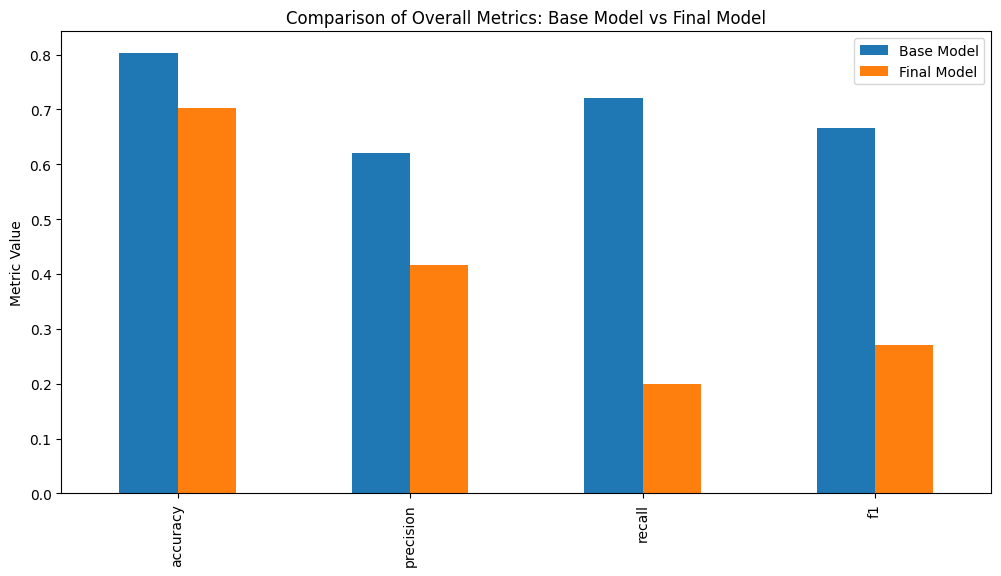

C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_12144\2464221156.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  return fp / (fp + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_12144\2464221156.py:19: RuntimeWarning: invalid value encountered in longlong_scalars
  return tn / (tn + fp)


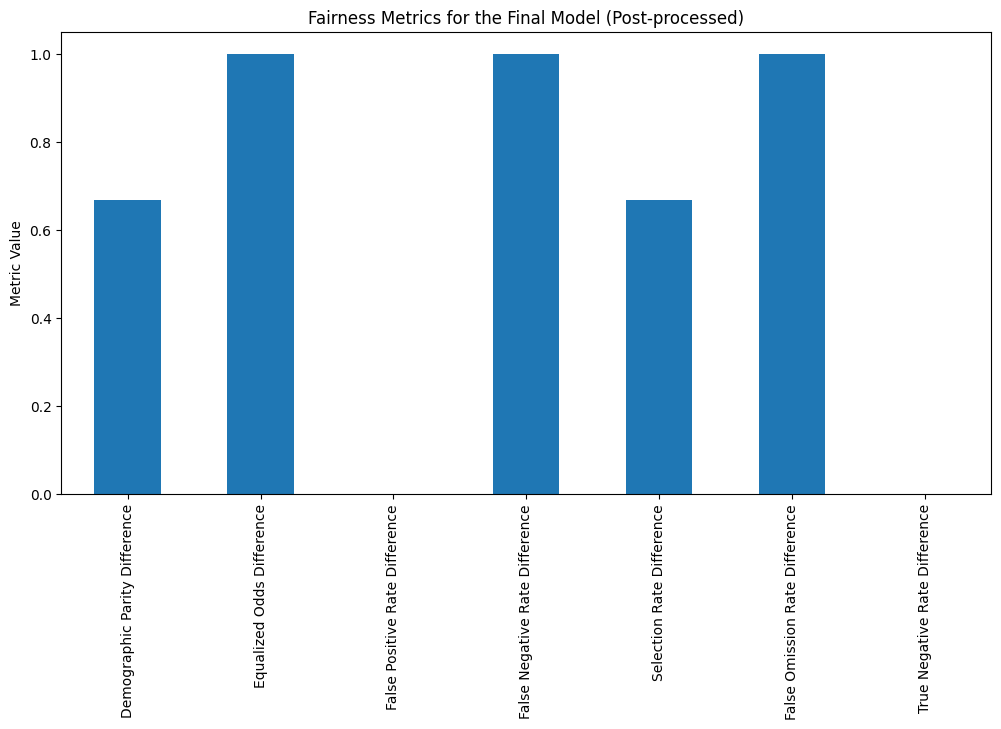

In [7]:
# Comparing the base model and final model (post-processed) metrics
base_metrics = metrics.overall
final_metrics = metrics_pp.overall

comparison_df = pd.DataFrame({
    'Base Model': base_metrics,
    'Final Model': final_metrics
})

# Plot comparison of overall metrics
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Overall Metrics: Base Model vs Final Model')
plt.ylabel('Metric Value')
plt.show()

# Fairness metrics for the final model (post-processed)
final_fairness_metrics = {
    'Demographic Parity Difference': demographic_parity_difference(y_test, y_pred_pp, sensitive_features=data.loc[X_test.index, 'racepctblack_bin']),
    'Equalized Odds Difference': equalized_odds_difference(y_test, y_pred_pp, sensitive_features=data.loc[X_test.index, 'racepctblack_bin']),
    'False Positive Rate Difference': false_positive_rate_difference(y_test, y_pred_pp, sensitive_features=data.loc[X_test.index, 'racepctblack_bin']),
    'False Negative Rate Difference': false_negative_rate_difference(y_test, y_pred_pp, sensitive_features=data.loc[X_test.index, 'racepctblack_bin']),
    'Selection Rate Difference': selection_rate_difference(y_pred_pp, sensitive_features=data.loc[X_test.index, 'racepctblack_bin']),
    'False Omission Rate Difference': false_omission_rate_difference(y_test, y_pred_pp, sensitive_features=data.loc[X_test.index, 'racepctblack_bin']),
    'True Negative Rate Difference': true_negative_rate_difference(y_test, y_pred_pp, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
}

final_fairness_df = pd.Series(final_fairness_metrics)

# Plot fairness metrics for the final model
final_fairness_df.plot(kind='bar', figsize=(12, 6))
plt.title('Fairness Metrics for the Final Model (Post-processed)')
plt.ylabel('Metric Value')
plt.show()

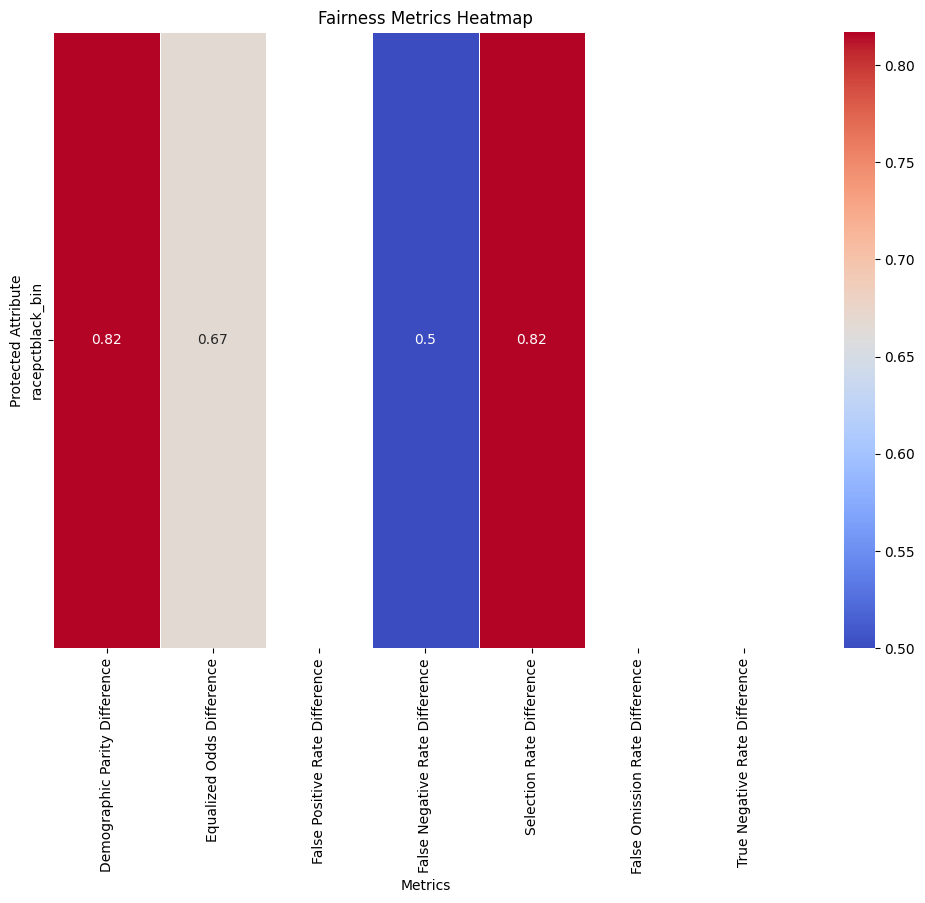

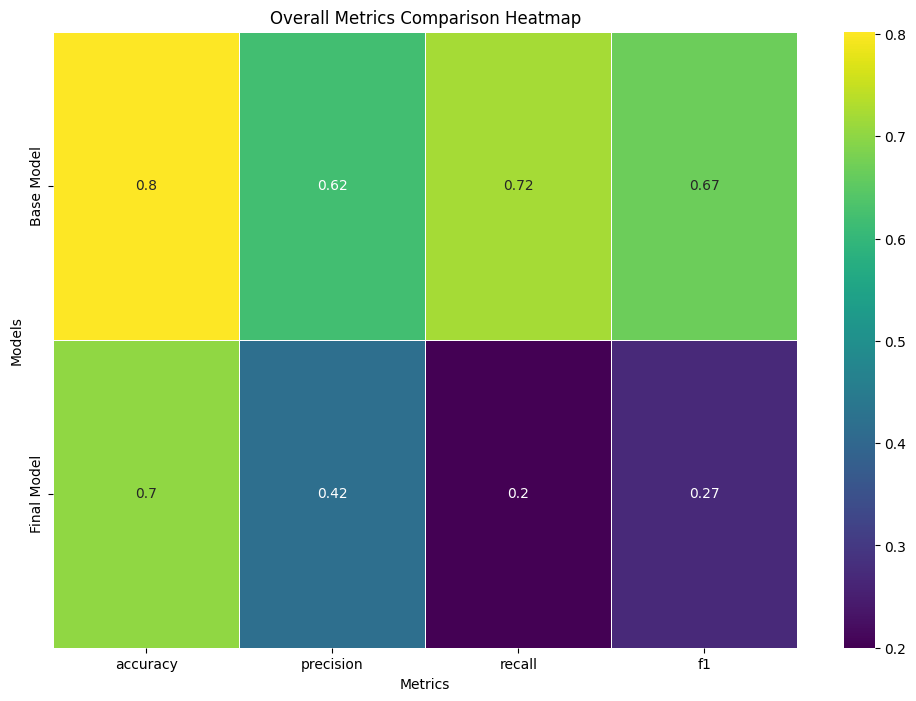

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap for fairness metrics
metrics_heatmap_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd],
    'Equalized Odds Difference': [eod],
    'False Positive Rate Difference': [fprd],
    'False Negative Rate Difference': [fnrd],
    'Selection Rate Difference': [srd],
    'False Omission Rate Difference': [for_diff],
    'True Negative Rate Difference': [tnr_diff]
}, index=['racepctblack_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Comparison heatmap for overall metrics
comparison_heatmap_data = pd.DataFrame({
    'Base Model': base_metrics,
    'Final Model': final_metrics
}).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()
